In [1]:
import requests
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sentence_transformers import SentenceTransformer, util
import numpy as np

/home/maximilian.laechelin/.local/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

api_key = 'api key'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/maximilian.laechelin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
#!gunzip GoogleNews-vectors-negative300.bin.gz

In [9]:
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
st_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [13]:
def get_channel_id(api_key, handle):
    search_url = 'https://www.googleapis.com/youtube/v3/search'
    search_params = {
        'part': 'snippet',
        'q': handle,  # Query for the handle
        'type': 'channel',
        'key': api_key
    }
    search_response = requests.get(search_url, params=search_params)
    search_data = search_response.json()
    if search_data['items']:
        return search_data['items'][0]['id']['channelId']
    return None

def get_uploads_playlist_id(api_key, channel_id):
    channel_url = f'https://www.googleapis.com/youtube/v3/channels'
    channel_params = {
        'part': 'contentDetails',
        'id': channel_id,
        'key': api_key
    }
    channel_response = requests.get(channel_url, params=channel_params)
    channel_data = channel_response.json()
    return channel_data['items'][0]['contentDetails']['relatedPlaylists']['uploads']

def get_video_ids(api_key, uploads_playlist_id):
    video_ids = []
    next_page_token = None
    while True:
        playlist_items_url = 'https://www.googleapis.com/youtube/v3/playlistItems'
        playlist_params = {
            'part': 'snippet',
            'playlistId': uploads_playlist_id,
            'maxResults': 100,
            'key': api_key,
            'pageToken': next_page_token  
        }
        videos_response = requests.get(playlist_items_url, params=playlist_params)
        videos_data = videos_response.json()
        video_ids += [item['snippet']['resourceId']['videoId'] for item in videos_data['items']]
        next_page_token = videos_data.get('nextPageToken')
        if not next_page_token:
            break
    return video_ids

def get_video_details(api_key, video_id):
    video_details_url = 'https://www.googleapis.com/youtube/v3/videos'
    video_params = {
        'part': 'snippet',
        'id': video_id,
        'key': api_key
    }
    video_response = requests.get(video_details_url, params=video_params)
    video_data = video_response.json()
    return video_data['items'][0]['snippet']['publishedAt']  # Return upload date

def get_video_comments(api_key, video_id):
    comments_url = 'https://www.googleapis.com/youtube/v3/commentThreads'
    comments_params = {
        'part': 'snippet',
        'videoId': video_id,
        'key': api_key,
        'maxResults': 200  
    }
    comments_response = requests.get(comments_url, params=comments_params)
    comments_data = comments_response.json()
    return comments_data.get('items', [])

def calculate_sentiment(comment_text):
    sentiment_scores = sid.polarity_scores(comment_text)
    return sentiment_scores['compound']

# Separate function to calculate Word2Vec proximity
def calculate_w2v_proximity(comment_text, w2v_model, target_word="trust"):
    comment_tokens = comment_text.split()
    if target_word in w2v_model and all(token in w2v_model for token in comment_tokens):
        return np.mean([w2v_model.similarity(token, target_word) for token in comment_tokens])
    return np.nan  # Return NaN if tokens are not in vocabulary

# Separate function to calculate Sentence Transformer proximity
def calculate_st_proximity(comment_text, st_model, target_word="trust"):
    comment_embedding = st_model.encode(comment_text, convert_to_tensor=True)
    trust_embedding = st_model.encode(target_word, convert_to_tensor=True)
    return util.pytorch_cos_sim(comment_embedding, trust_embedding).item()

# Function to analyze comments
def analyze_comments(video_ids, api_key):
    comment_results = []
    for video_id in video_ids:
        upload_date = get_video_details(api_key, video_id)
        comments = get_video_comments(api_key, video_id)
        
        for comment in comments:
            comment_text = comment['snippet']['topLevelComment']['snippet']['textDisplay']
            comment_date = comment['snippet']['topLevelComment']['snippet']['publishedAt']

            # Calculate sentiment and proximity
            sentiment_score = calculate_sentiment(comment_text)
            w2v_proximity = calculate_w2v_proximity(comment_text, w2v_model)
            st_proximity = calculate_st_proximity(comment_text, st_model)

            comment_results.append({
                'video_id': video_id,
                'comment_date': comment_date,
                'upload_date': upload_date,
                'comment_text': comment_text,
                'sentiment_score': sentiment_score,
                'w2v_proximity_to_trust': w2v_proximity,
                'st_proximity_to_trust': st_proximity
            })
    return pd.DataFrame(comment_results)

# Plot sentiment and proximity scores with events
def plot_sentiment_and_proximity(df, events):
    df['comment_date'] = pd.to_datetime(df['comment_date'])
    df['upload_date'] = pd.to_datetime(df['upload_date'])
    
    # Aggregate sentiment and proximity by month for comments
    monthly_sentiment_comments = df.set_index('comment_date').resample('M')['sentiment_score'].mean().reset_index()
    monthly_w2v_proximity = df.set_index('comment_date').resample('M')['w2v_proximity_to_trust'].mean().reset_index()
    monthly_st_proximity = df.set_index('comment_date').resample('M')['st_proximity_to_trust'].mean().reset_index()
    
    plt.figure(figsize=(14, 12))

    # Sentiment Score Plot
    plt.subplot(3, 1, 1)
    plt.plot(monthly_sentiment_comments['comment_date'], monthly_sentiment_comments['sentiment_score'], marker='o', label='Monthly Comment Sentiment', color='blue')
    plt.title('Monthly Average Sentiment Score from Comments')

    # Add vertical lines for events
    for event_date, event_label in events.items():
        plt.axvline(x=event_date, color='gray', linestyle='--', lw=2)
        plt.text(event_date + pd.Timedelta(days=10), plt.ylim()[1] * 0.9, event_label, rotation=90, verticalalignment='top', horizontalalignment='left')

    # Word2Vec Proximity Plot
    plt.subplot(3, 1, 2)
    plt.plot(monthly_w2v_proximity['comment_date'], monthly_w2v_proximity['w2v_proximity_to_trust'], marker='x', label='W2V Proximity to "trust"', color='green')
    plt.title('Monthly Average Word2Vec Proximity to "trust"')

    # Add vertical lines for events
    for event_date, event_label in events.items():
        plt.axvline(x=event_date, color='gray', linestyle='--', lw=2)
        plt.text(event_date + pd.Timedelta(days=10), plt.ylim()[1] * 0.9, event_label, rotation=90, verticalalignment='top', horizontalalignment='left')

    # Sentence Transformer Proximity Plot
    plt.subplot(3, 1, 3)
    plt.plot(monthly_st_proximity['comment_date'], monthly_st_proximity['st_proximity_to_trust'], marker='x', label='ST Proximity to "trust"', color='red')
    plt.title('Monthly Average Sentence Transformer Proximity to "trust"')

    # Add vertical lines for events
    for event_date, event_label in events.items():
        plt.axvline(x=event_date, color='gray', linestyle='--', lw=2)
        plt.text(event_date + pd.Timedelta(days=10), plt.ylim()[1] * 0.9, event_label, rotation=90, verticalalignment='top', horizontalalignment='left')

    plt.tight_layout()
    plt.show()


In [11]:
# Main Execution
handles = ['@AudiDE', '@Audi']
all_comments_df = pd.DataFrame()

for handle in handles:
    channel_id = get_channel_id(api_key, handle)
    if not channel_id:
        print(f"Channel not found for handle {handle}")
        continue
    
    uploads_playlist_id = get_uploads_playlist_id(api_key, channel_id)
    video_ids = get_video_ids(api_key, uploads_playlist_id)
    comments_df = analyze_comments(video_ids, api_key)
    all_comments_df = pd.concat([all_comments_df, comments_df], ignore_index=True)

/tmp/ipykernel_3704480/62322044.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sentiment_comments = df.set_index('comment_date').resample('M')['sentiment_score'].mean().reset_index()
/tmp/ipykernel_3704480/62322044.py:120: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_w2v_proximity = df.set_index('comment_date').resample('M')['w2v_proximity_to_trust'].mean().reset_index()
/tmp/ipykernel_3704480/62322044.py:121: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_st_proximity = df.set_index('comment_date').resample('M')['st_proximity_to_trust'].mean().reset_index()


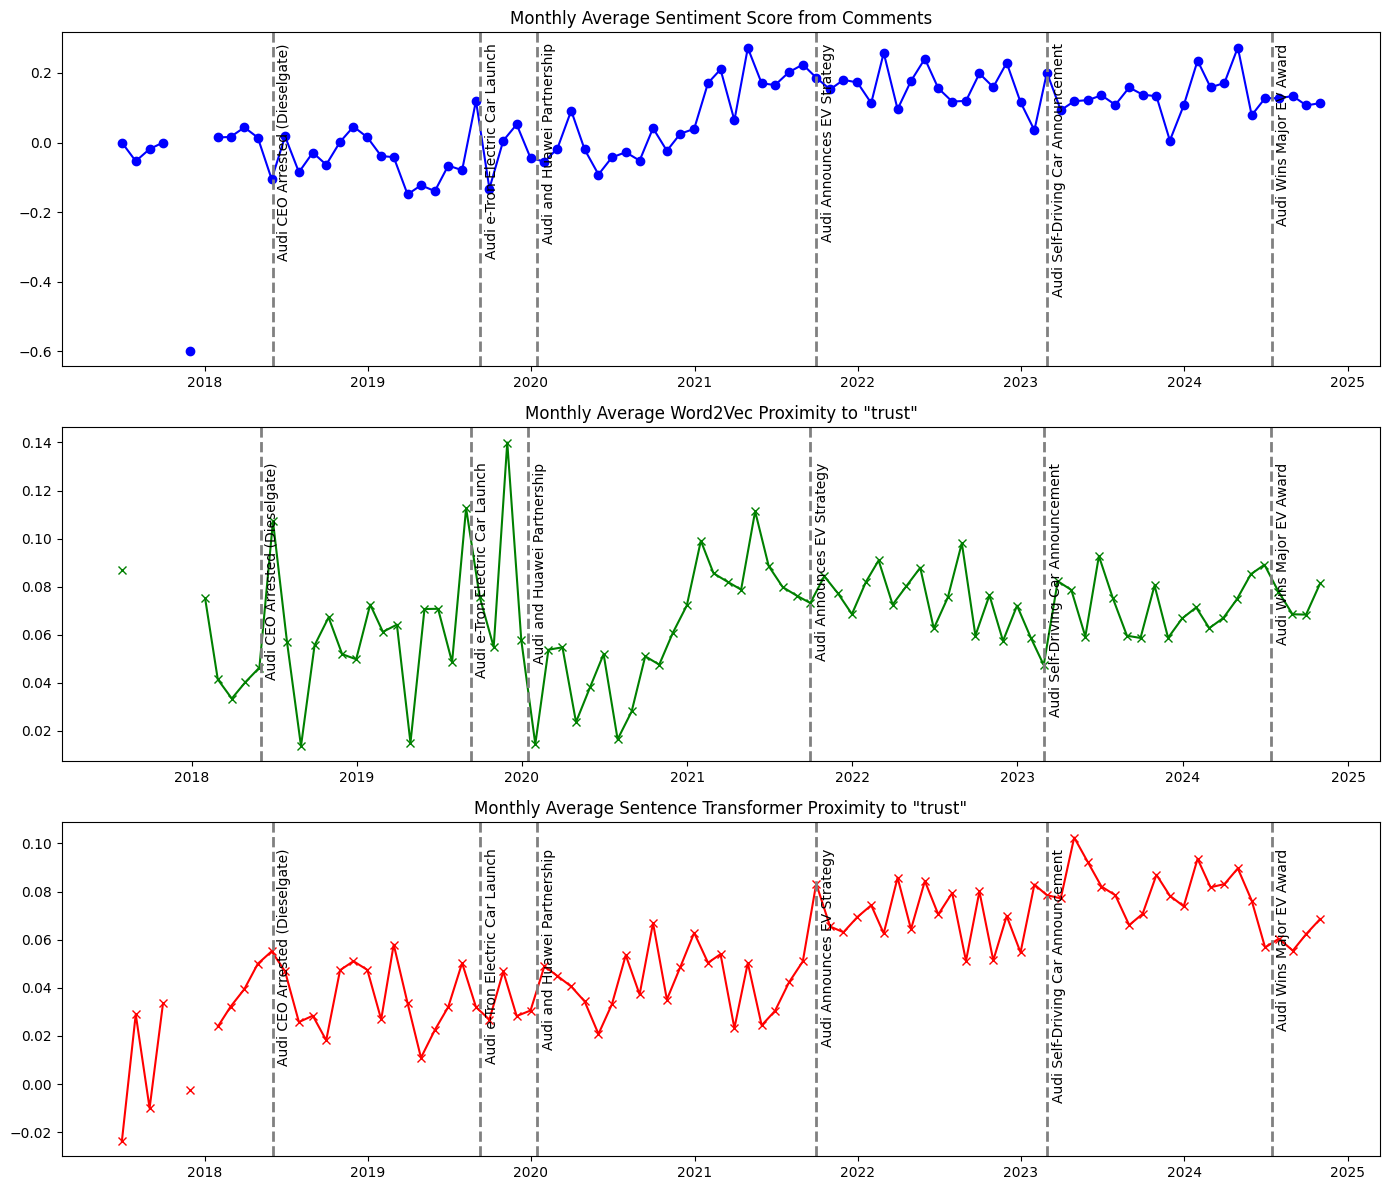

In [14]:
events = {
    '2018-06-03': 'Audi CEO Arrested (Dieselgate)',
    '2019-09-10': 'Audi e-Tron Electric Car Launch',
    '2020-01-15': 'Audi and Huawei Partnership',
    '2021-09-30': 'Audi Announces EV Strategy',
    '2023-03-01': 'Audi Self-Driving Car Announcement',
    '2024-07-15': 'Audi Wins Major EV Award'
}
events = {pd.to_datetime(date): event for date, event in events.items()}

# Plot sentiment and proximity scores over time
plot_sentiment_and_proximity(all_comments_df, events)